In [1]:
%matplotlib inline
!pip install deeptrack

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/fix-resolution/examples/tutorials/distinguishing_particles_in_brightfield_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# DeepTrack 2.0 - Distinguishing particles in brightfield microscopy

This tutorial demonstrates how to use a U-net to track and distinguish particles of different sizes in brightfield microscopy.

This tutorial should be read after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_multiple_particles_unet_tutorial](tracking_multiple_particles_unet_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particles

We consider spherical particles of two different sizes. The particles are instances of the class `Sphere`, which takes the following inputs:

* `position`: The lateral position of the particle
* `z` (optional): The axial distance of the particle perpendicualr to the focal plane
* `position_unit`: "pixel" or "meter", defines the scale factor of the particle position
* `radius`: The radius of the particle in meters
* `refractive_index`: The refractive index of the particle

In this example, the positions of the particles are randomly sampled with a lateral position between 0 and 256 pixels in the focal plane, and an axial position between -10 to 10 pixels from the focal plane. The smaller particle has a radius between 200 and 250 nm, while the larger has a radius between 400 and 500 nm. The real part of their refractive index is 1.45, while the imaginary part is between 0.1 and 0.15 (corresponding to the absorption coefficient). Finally we define a dummy-property, `particle_type`, which helps us distinguish between the particles.

In [3]:
small_particle = dt.Sphere(
    position=lambda: np.random.rand(2) * 128,
    z=lambda: - 10 + np.random.rand() * 20,
    position_unit="pixel",
    radius=lambda: 200e-9 + np.random.rand() * 50e-9,
    refractive_index=lambda: 1.45 + (0.02j + np.random.rand() * 0.01j),
    particle_type = 0
)

large_particle = dt.Sphere(
    position=lambda: np.random.rand(2) * 128,
    z=lambda: -10 + np.random.rand() * 20,
    position_unit="pixel",
    radius=lambda: 400e-9 + np.random.rand() * 100e-9,
    refractive_index=lambda: 1.45 + (0.02j + np.random.rand() * 0.01j),
    particle_type = 1
)

## 3. Define the optics 

Next, we need to define the properties of the optical system. Here, we use the class `Brightfield`, which uses particles with a defined refractive_index and illuminates them coherently (see also [optics_example](../module-examples/optics_example.ipynb)). It takes the following inputs:

* `wavelength`: The wavelength of the illuminting light (m)
* `NA`: The numerical aperature
* `resolution`: The effective camera pixel size (m)
* `magnification`: The magnification of the optical device
* `output_region`: The position and size of the camera sensor in pixels (x, y, width_x, width_y)
* `refractive_index_medium`: The refractive index of the medium the scatterers are immersed in. 
* `illumination`: The light illuminating to the sample (if undefined, the sample is illuminated homogenously with intensity 1)

To simulate incoherent white light, we define multiple optical devices in a range of wavelengths from 400 to 700 nm. The number of optical devices is a trade-off between accuracy and speed: in most cases a few (~3) wavelengths will be enough. Moreover, we create an instance of the class `IlluminationGradient`, which adds an intensity gradient to the illuminating light.

In [4]:
spectrum = np.linspace(400e-9, 700e-9, 3)

illumination_gradient = dt.IlluminationGradient(gradient=lambda: np.random.randn(2) * 0.0002)

brightfield_microscope = [dt.Brightfield(
                            wavelength=wavelength,
                            NA=1,
                            resolution=1e-6,
                            magnification=10,
                            refractive_index_medium=1.33,
#                             illumination=illumination_gradient,
                            upsample=2,
                            output_region=(0, 0, 128, 128))
                          for wavelength 
                          in spectrum]

## 4. Define noises

The noise in the system is Poisson distributed with SNR between 50 and 100.

In [5]:
noise = dt.Poisson(snr=lambda: 50 + np.random.rand() * 50)

## 5. Combine the features 

The sample contains 5 to 24 small particles, and 5 to 24 large particles. It is illuminated with the brightfield optics defined above. We use the python function `sum()` to add the optical devices together. This is equivalent to the more verbose statement `optics[0](sample) + optics[1](sample) + ...`

In [6]:
number_of_small_particles = lambda: np.random.randint(5, 15)
number_of_large_particles = lambda: np.random.randint(5, 15)

sample = (small_particle^number_of_small_particles) & (large_particle^number_of_large_particles)

incoherently_illuminated_sample = sum([brightfield_microscope_one_wavelegth(sample) 
                                       for brightfield_microscope_one_wavelegth 
                                       in brightfield_microscope])

## 6. Augmenting the images

Simulating many images is slow. to speed up the training, we use augmentation. These are special features that allow us to resolve more images before resolving the base feature (`brightfield_microscope_one_wavelegth`). We use 3 augmentations, `FlipLR`, which mirrors the image left to right, `FlipUD`, which mirrors the image up to down, and `FlipDiagonal`, which mirrors the image along the main diagonal. This results in an 8-fold increase in the numebr of images, and thus in the speed of the code (roughly).

We add the noise after the augmentation as a cheap way to make the images even more diverse.

Finally we normalize the images using `NormalizeMinMax`, which transforms the images to values between 0 and 1.

In [7]:
augmented_image = incoherently_illuminated_sample

image_of_particles = augmented_image >> noise >> dt.NormalizeMinMax()

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle position, Poisson noise, etc.). Afterwards we call the method `.plot()` to generate and display the image.

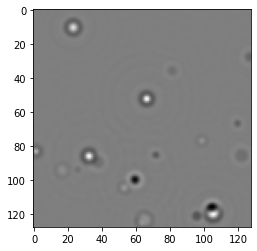

In [8]:
 for _ in range(8):
    incoherently_illuminated_sample.update()
    incoherently_illuminated_sample.plot(cmap="gray")

## 7. Create the target images

We define a function that uses the generated images to create the target images to be used in the training. The target is an image of shape (256, 256, 3), where the last dimension represents three classes. In other words, each pixel in the input image is classified into one of three classes:
1. The first class is the null-class, representing the background. A pixel belongs to the null class if it doesn't belong to any other class. 
2. The second class is 1 if the pixel is within 3 pixels of a small particle.
3. The third class is 1 if the pixel is within 3 pixels of a large particle.

We also show images and targets side by side.

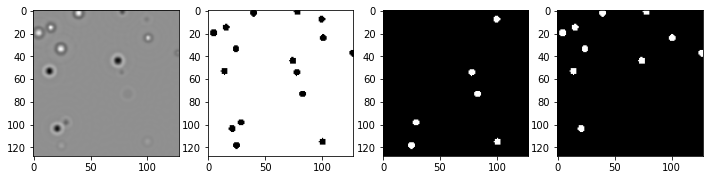

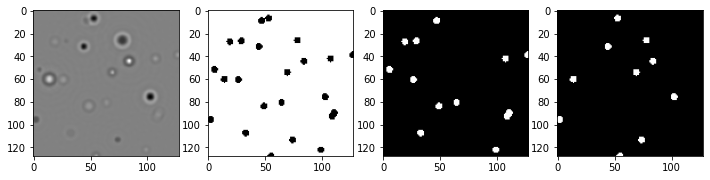

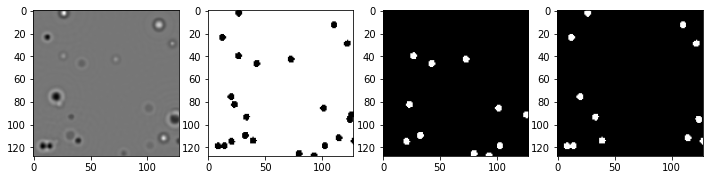

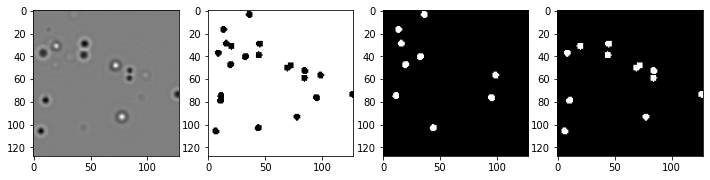

In [9]:
def get_target_image(image_of_particles):
    label = np.zeros((*image_of_particles.shape[:2], 3))
    
    X, Y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]), 
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]
            distance_map = (X - position[1])**2 + (Y - position[0])**2
            label[distance_map < 9, property["particle_type"] + 1] = 1
            
    label[..., 0] = 1 - np.max(label[..., 1:], axis=-1)
    
    return label

# Show images
for i in range(4):
    augmented_image.update()
    
    image_of_particles = augmented_image.resolve()
    
    label_of_particles = get_target_image(image_of_particles)
    
    plt.figure(figsize=(12, 9))
    
    plt.subplot(1, 4,1)
    plt.imshow(image_of_particles[..., 0], cmap="gray")
    
    plt.subplot(1,4,2)
    plt.imshow(label_of_particles[..., 0], cmap="gray")
    
    plt.subplot(1,4,3)
    plt.imshow(label_of_particles[..., 1], cmap="gray")
    
    plt.subplot(1,4,4)
    plt.imshow(label_of_particles[..., 2], cmap="gray")
    plt.show()

## 8. Define image generator

We define a generator that creates images and targets in batches of 8.

In [10]:
generator = dt.generators.ContinuousGenerator(
    augmented_image, 
    get_target_image,
    batch_size=8,
    min_data_size=256,
    max_data_size=512
)

## 9. Define loss function

We also define a custom loss function. The loss function is categorical loss, where each class is wighted by 1-p, where p is is the proportion of all pixels in that class which is 1 in the label. This helps us avoid the obvious local minimum of classifying all pixels as the null-class.

In [11]:
import tensorflow.keras.backend as K

eps = 1e-6

def softmax_categorical(T, P):
    classwise_weight = K.mean(1 - T, axis=(1, 2), keepdims=True)
    true_error = K.mean(T * K.log(P + eps) * classwise_weight, axis=-1)
    return -K.mean(true_error)

## 10. Define the neural network model

The neural network architecture used is a U-net, which is a fully convoltional model used for image to image transformations (see also [models_example](../module-examples/models_example.ipynb)). We add a softmax activation to the final layer. 

In [12]:
model = dt.models.unet(
    (None, None, 1), 
    conv_layers_dimensions=[8, 16, 32],
    base_conv_layers_dimensions=[32, 32], 
    number_of_outputs=3,
    output_activation="softmax",
    loss=softmax_categorical
)

## 10. Train the model

We train the model by calling `.fit()`. This step will take some time (up to ten minutes on CPU).

In [13]:
with generator:
    model.fit(generator, epochs=300)

Generating 257 / 256 samples before starting training
Epoch 1/300
32/32 [==============================] - 7s 97ms/step - loss: 0.0228
Epoch 2/300
32/32 [==============================] - 3s 106ms/step - loss: 0.0174
Epoch 3/300
32/32 [==============================] - 3s 105ms/step - loss: 0.0127
Epoch 4/300
32/32 [==============================] - 3s 109ms/step - loss: 0.0108
Epoch 5/300
32/32 [==============================] - 3s 105ms/step - loss: 0.0093
Epoch 6/300
32/32 [==============================] - 3s 103ms/step - loss: 0.0076
Epoch 7/300
32/32 [==============================] - 3s 105ms/step - loss: 0.0069
Epoch 8/300
32/32 [==============================] - 3s 98ms/step - loss: 0.0064
Epoch 9/300
32/32 [==============================] - 3s 101ms/step - loss: 0.0064
Epoch 10/300
32/32 [==============================] - 3s 96ms/step - loss: 0.0067
Epoch 11/300
32/32 [==============================] - 3s 104ms/step - loss: 0.0057
Epoch 12/300
32/32 [=========================

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output beside the input image and the ground truth. 

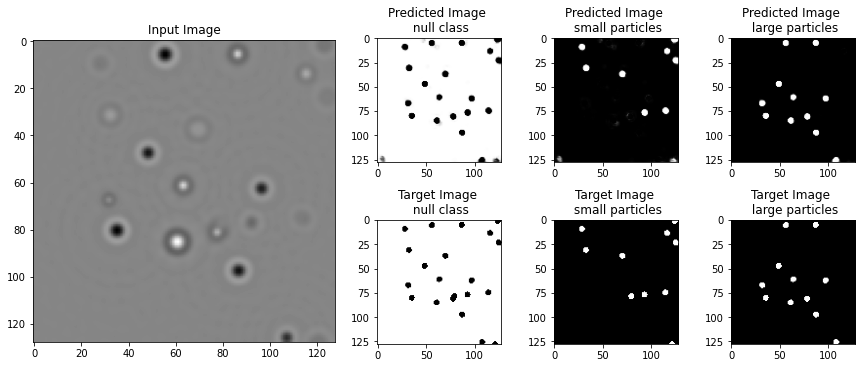

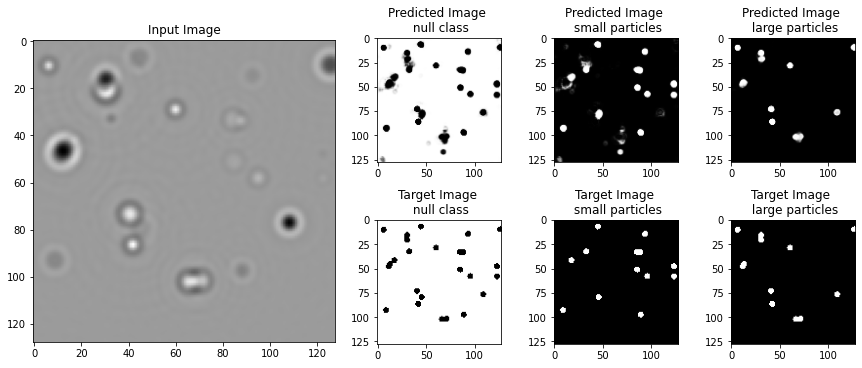

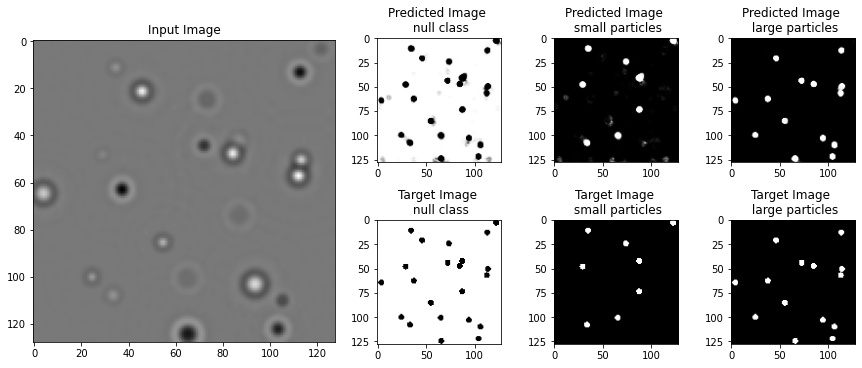

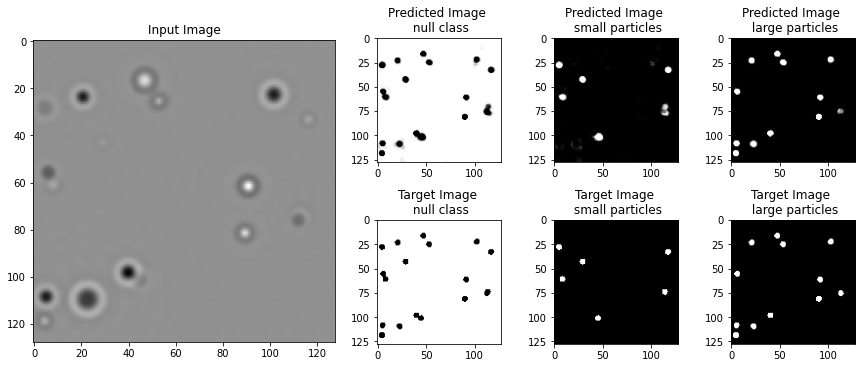

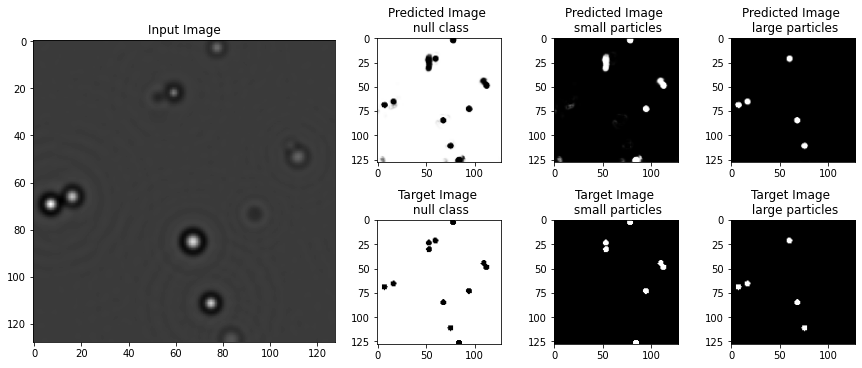

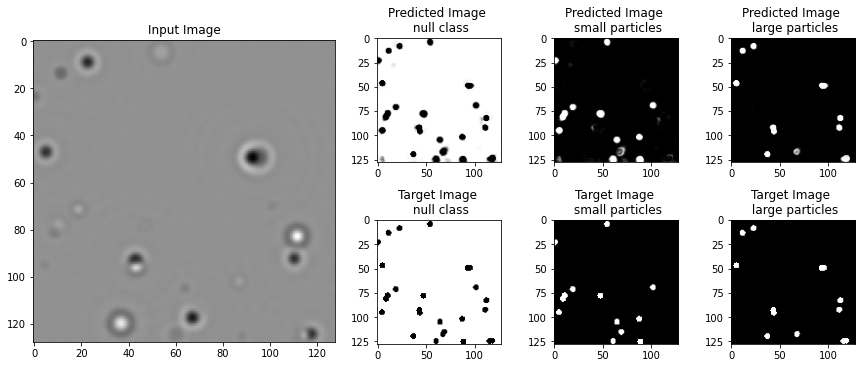

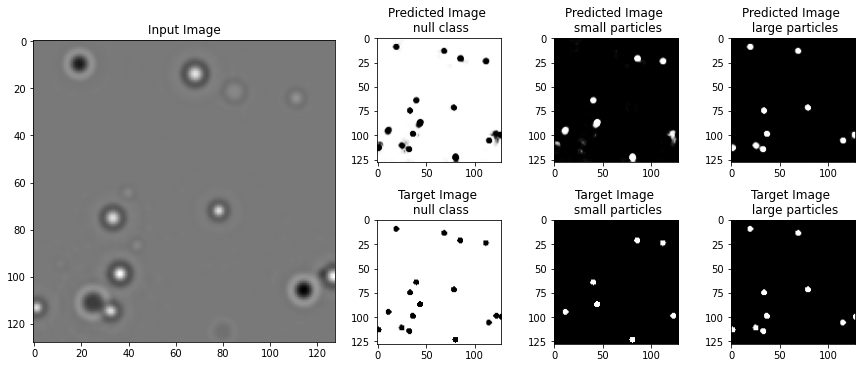

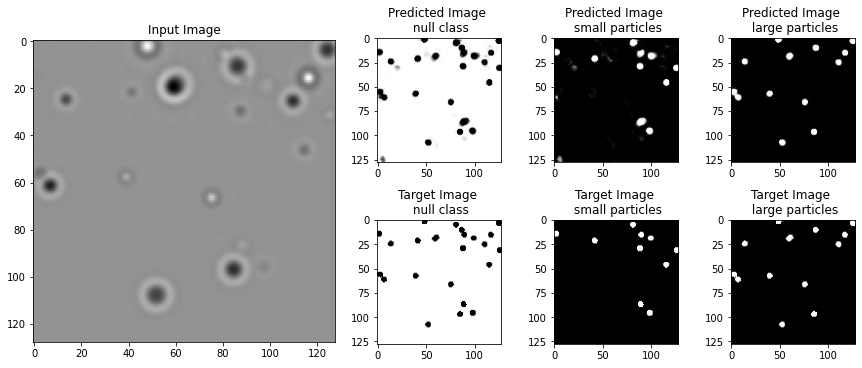

In [14]:
# generator[0] extracts a single batch
input_image, target_image = generator[0]

predicted_image = model.predict(input_image)

for i in range(input_image.shape[0]):
    
    
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)

    gs = fig.add_gridspec(2, 5)

    fig.add_subplot(gs[0:2, 0:2])
    plt.imshow(input_image[i, :, :, 0], cmap="gray")
    plt.title("Input Image")

    fig.add_subplot(gs[0, 2])
    plt.imshow(predicted_image[i, :, :, 0], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n null class")
    
    fig.add_subplot(gs[0, 3])
    plt.imshow(predicted_image[i, :, :, 1], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n small particles")
    
    fig.add_subplot(gs[0, 4])
    plt.imshow(predicted_image[i, :, :, 2], cmap="gray", vmin=0, vmax=1)
    plt.title("Predicted Image \n large particles")

    
    fig.add_subplot(gs[1, 2])
    plt.imshow(target_image[i, :, :, 0], cmap="gray", vmin=0, vmax=1)
    plt.title("Target Image \n null class")
    
    fig.add_subplot(gs[1, 3])
    plt.imshow(target_image[i, :, :, 1], cmap="gray", vmin=0, vmax=1)
    plt.title("Target Image \n small particles")
    
    fig.add_subplot(gs[1, 4])
    plt.imshow(target_image[i, :, :, 2], cmap="gray", vmin=0, vmax=1)
    plt.title("Target Image \n large particles")  

    plt.show()